# Feature Engineering—SINGLE ROUTE

In [1]:
route = 'M15'
import pandas as pd
import numpy as np
df = pd.read_parquet(f'data/nyc_buses_with_passenger_counts_20210401_20210630_{route}_cleaned.parquet')
df.shape

(161072, 14)

In [2]:
df.sample(n=20)

,timestamp,service_date,hour,minute,route_short,direction,vehicle_id,lat,lon,next_stop_id,next_stop_d,next_stop_d_along_route,passenger_count,next_stop_id_cleaned
index,,,,,,,,,,,,,,
79125950,2021-06-17 07:04:54,2021-06-17,7,4,M15,1,6037,40.7631,-73.9625,MTA_401764,207.82,5384.29,3.0,401764
35837349,2021-05-23 08:55:18,2021-05-23,8,55,M15,0,6067,40.7119,-73.9980,MTA_402088,4.85,1816.17,4.0,402088
33573545,2021-05-21 16:43:22,2021-05-21,16,43,M15,0,6037,40.7748,-73.9509,MTA_401715,303.38,8334.46,17.0,401715
5330266,2021-05-06 08:15:17,2021-05-06,8,15,M15,1,6069,40.7064,-74.0056,MTA_405337,295.55,13326.70,3.0,405337
39777700,2021-05-25 13:50:22,2021-05-25,13,50,M15,0,6101,40.7902,-73.9397,MTA_401724,193.06,12268.30,1.0,401724
47142000,2021-05-29 10:40:59,2021-05-29,10,40,M15,1,6039,40.7102,-73.9918,MTA_904920,19.05,11996.00,0.0,904920
8861066,2021-05-07 23:35:18,2021-05-07,23,35,M15,0,6037,40.7419,-73.9749,MTA_401694,12.91,5941.08,26.0,401694
88626721,2021-06-22 17:32:27,2021-06-22,17,32,M15,1,6045,40.7927,-73.9409,MTA_401744,130.36,1552.93,4.0,401744
50387696,2021-05-31 21:33:52,2021-05-31,21,33,M15,0,6071,40.7776,-73.9489,MTA_401716,189.09,8572.88,10.0,401716


## geographic transformations

#### as-is

#### use a distance variable

#### create clusters

In [3]:
# https://bmanikan.medium.com/feature-engineering-all-i-learned-about-geo-spatial-features-649871d16796

from sklearn.cluster import KMeans

def cluster(df):
  '''
  input: dataframe containing Latitude(x) and Longitude(y) coordinates
  output: series of cluster labels that each row of coordinates belongs to.
  '''
  model = KMeans(n_clusters=200)
  labels = model.fit_predict((df[['direction','lat', 'lon', 'next_stop_id_cleaned']]))
  return labels

df['cluster_id'] = cluster(df)

/opt/bin/mambaforge/envs/tensorflow/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (196) found smaller than n_clusters (200). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


<AxesSubplot:xlabel='lat', ylabel='lon'>

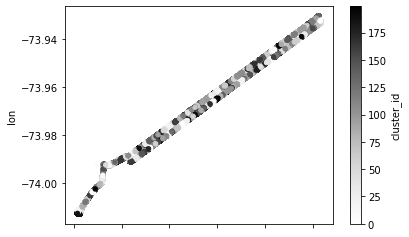

In [4]:
df.plot(x="lat", y="lon", kind="scatter", c="cluster_id")

#### transformation of coordinates

In [5]:
# Option A (using UTM)
# https://gis.stackexchange.com/questions/212723/how-can-i-convert-lon-lat-coordinates-to-x-y/352085
import utm

def utm_transform(s):
    x, y, a, b = utm.from_latlon(s['lat'],s['lon'])
    return pd.Series([x,y],index=['utm_x','utm_y'])

df[['utm_x', 'utm_y']] = df.apply(utm_transform, axis=1, result_type="expand")

In [6]:
# # Option B (projected)
# # https://gis.stackexchange.com/questions/212723/how-can-i-convert-lon-lat-coordinates-to-x-y/352085

# from pyproj import Transformer
# transformer = Transformer.from_crs("epsg:4326", "epsg:2236")

# def pyproj_transform(s):
#     x, y = transformer.transform(s['lon'], s['lat'])
#     return pd.Series([x,y],index=['pyproj_x','pyproj_y'])

# df[['pyproj_x', 'pyproj_y']] = df.apply(pyproj_transform, axis=1, result_type="expand")

In [7]:
# TO DO?
# # https://bmanikan.medium.com/feature-engineering-all-i-learned-about-geo-spatial-features-649871d16796
# #  By rotating them, they would provide more spatial information for the Tree type models. which are extremely beneficial when compared to normal x-y coordinates. They help to visualize coordinates in different perception (viewing angle) and put some insights on the data that the model can learn from it. we can also do this rotation by Principal Component Analysis(PCA) which can give more options in our bucket. Will see it in a bit!

# def rotation(df):
#   '''
#   # most frequently used degrees are 30,45,60
#   input: dataframe containing Latitude(x) and Longitude(y)
#   '''
#   rot_45_x = (0.707 * df['lat']) + (0.707 * df['lon'])
#   rot_45_y = (0.707 * df['lon']) + (0.707 * df['lat'])
#   rot_30_x = (0.866 * df['lat']) + (0.5 * df['lon'])
#   rot_30_y = (0.866 * df['lon']) + (0.5 * df['lat'])
#   return rot_45_x, rot_45_y, rot_30_x, rot_30_y

# #TODO check that it was correct to swap x=lat and y=lon

# df[['rot_45_x', 'rot_45_y', 'rot_30_x', 'rot_30_y'] = 

#### TODO Combine route_id and direction into a single feature (for when we do citywide model)

## time series transformations

#### Month, week, and day of month

In [8]:
import datetime as dt

df['month'] = df.timestamp.dt.month
df['week'] = df.timestamp.dt.isocalendar().week.astype(int)
df['day'] = df.timestamp.dt.day

#### Day of week flag

In [9]:
df['service_date'] = pd.to_datetime(df['service_date'])
df['day_of_week'] = df['service_date'].dt.weekday
df['is_weekend'] = df['day_of_week'].isin([5, 6])

In [10]:
# one-hot encode day of week
df = pd.concat((df, pd.get_dummies(df['service_date'].dt.day_name())), axis=1)

#### Convert day of week to cyclical

In [11]:
df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 7))
df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 7))

#### Convert hour to cyclical

In [12]:
# cyclical time for hour

import math

# normalize
df["hour_norm"] = 2 * math.pi * df["hour"] / df["hour"].max()

# calc cyclical features
df["hour_cos"] = np.cos(df["hour_norm"])
df["hour_sin"] = np.sin(df["hour_norm"])

In [13]:
## Final Cleaning

#### drop columns

In [14]:
df = df.drop(['route_short', 'next_stop_id', 'timestamp','service_date', 'minute'], axis=1)

#### reorder columns

In [15]:
#### reorder columns

order = ['vehicle_id',
         'month',
         'week',
         'day','hour',
         'day_of_week',
         'is_weekend',
         'Monday',
         'Tuesday',
         'Wednesday',
         'Thursday',
         'Friday',
         'Saturday',
         'Sunday',
         'day_of_week_sin',
         'day_of_week_cos',
         'hour_norm',
         'hour_cos',
         'hour_sin',
         'cluster_id',
         'lat',
         'lon',
         'utm_x',
         'utm_y',
         'direction',
         'next_stop_id_cleaned',
         'next_stop_d',
         'next_stop_d_along_route',
         'passenger_count']

df = df.loc[:, order]

In [16]:
df.sample(n=25)

,vehicle_id,month,week,day,hour,day_of_week,is_weekend,Monday,Tuesday,Wednesday,...,cluster_id,lat,lon,utm_x,utm_y,direction,next_stop_id_cleaned,next_stop_d,next_stop_d_along_route,passenger_count
index,,,,,,,,,,,,,,,,,,,,,
76064059,6105,6,24,15,15,1,False,0,1,0,...,154,40.8000,-73.9356,589788.478931,4.517101e+06,1,401740,175.54,663.37,3.0
33860366,6049,5,20,21,18,4,False,0,0,0,...,139,40.7315,-73.9824,585928.750563,4.509450e+06,0,401687,77.40,2604.32,0.0
21573323,6079,5,19,15,6,5,True,0,0,0,...,43,40.8032,-73.9325,590045.661643,4.517459e+06,1,401732,0.00,0.00,1.0
22224141,6037,5,19,15,14,5,True,0,0,0,...,72,40.7748,-73.9540,588269.668876,4.514284e+06,1,401756,239.30,3935.78,14.0
50827491,6035,6,22,1,7,1,False,0,1,0,...,7,40.7320,-73.9852,585691.666133,4.509502e+06,1,404105,158.66,9287.81,8.0
92877422,6067,6,25,24,20,3,False,0,0,0,...,139,40.7312,-73.9827,585903.803256,4.509416e+06,0,401687,121.06,2604.32,1.0
91043202,6063,6,25,23,22,2,False,0,0,1,...,30,40.7118,-73.9994,584518.122182,4.507246e+06,1,903054,3.16,12220.30,17.0
85982737,6051,6,25,21,11,0,False,1,0,0,...,35,40.7556,-73.9680,587113.289588,4.512139e+06,1,401768,129.96,6260.82,11.0
82728755,6059,6,24,18,21,4,False,0,0,0,...,115,40.7095,-74.0016,584335.193041,4.506989e+06,0,401670,141.48,1505.86,6.0


In [17]:
df.columns

Index(['vehicle_id', 'month', 'week', 'day', 'hour', 'day_of_week',
       'is_weekend', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
       'Saturday', 'Sunday', 'day_of_week_sin', 'day_of_week_cos', 'hour_norm',
       'hour_cos', 'hour_sin', 'cluster_id', 'lat', 'lon', 'utm_x', 'utm_y',
       'direction', 'next_stop_id_cleaned', 'next_stop_d',
       'next_stop_d_along_route', 'passenger_count'],
      dtype='object')

In [18]:
df.dtypes

vehicle_id                  object
month                        int64
week                         int64
day                          int64
hour                         int64
day_of_week                  int64
is_weekend                    bool
Monday                       uint8
Tuesday                      uint8
Wednesday                    uint8
Thursday                     uint8
Friday                       uint8
Saturday                     uint8
Sunday                       uint8
day_of_week_sin            float64
day_of_week_cos            float64
hour_norm                  float64
hour_cos                   float64
hour_sin                   float64
cluster_id                   int32
lat                        float64
lon                        float64
utm_x                      float64
utm_y                      float64
direction                    int64
next_stop_id_cleaned        object
next_stop_d                float64
next_stop_d_along_route    float64
passenger_count     

In [19]:
df['next_stop_id_cleaned'] = df['next_stop_id_cleaned'].astype(int)

### TODO future

# dump an engineered table

In [20]:
df.to_parquet(f'data/nyc_buses_with_passenger_counts_20210401_20210630_{route}_features.parquet')